# **Lab 6 (SOLUTIONS)**

TI3155TU Deep Learning (2024 - 2025)

Author: Elena Congeduti 

Most of the material has been adapted from 
[Transfer learning with ResNet-50 in PyTorch](https://www.kaggle.com/code/pmigdal/transfer-learning-with-resnet-50-in-pytorch/notebook).

# Instructions
We recommend that you fork the lab notebooks by selecting `Copy & Edit` on the notebook's homepage. This will create a copy in your Kaggle repository, allowing you to work on it and save your progress as you go. Kaggle provides a pre-configured virtual environment, which means that most of the libraries we will use are already downloaded and ready to use. Therefore, you typically do **not** need to `pip install` additional resources.

Alternatively, to work on Google Colab, you just need to select the `Open in Colab` option in the notebook's homepage menu. Finally, if you want to work locally, you will need to set up your own virtual environment. Check the Lab Instructions in [Learning Material](https://brightspace.tudelft.nl/d2l/le/content/682797/Home?itemIdentifier=D2L.LE.Content.ContentObject.ModuleCO-3812764) on Brightspace for detailed information on the virtual environment configuration.

These labs include programming exercises and insight questions. Follow the instructions in the notebook. Fill in the text blocks to answer the questions and write your own code to solve the programming tasks within the designated part of the code blocks:

```python
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################


#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################
```

Solutions will be shared the week after the lab is published. Note that these labs are designed for practice and are therefore **ungraded**.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

!pip install torchsummary
from torchsummary import summary

import torch
from torchvision import datasets, models, transforms

import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In this lab we will work at the example we have discussed in class: classification of alien and predator images. Let us start by exploring the dataset and defining the learning problem.

# 1 Dataset 
When starting a deep learning project, it's always a good idea to take a close look at the data. The dataset is already uploaded in the notebook, and you can find it in the Input section on the right. There, you can have a first loot at the folder structure, the number of samples, format etc. This will make it easier to navigate the dataset and access individual samples.

If you take a moment to explore the folder and you’ll find a training set with 347 images of aliens and 347 of predators and a validation set with 100 images of aliens and 100 images of predators.

In [2]:
#set random seed
np.random.seed(42)

# input path
input_path = "../input/images/data/"

#sample two random images from training and validation
train_ind = np.random.randint(0,347,size = 2)
valid_ind = np.random.randint(0,100,size =2)

sample_img_paths = []

sample_img_paths.append('train/alien/'+str(train_ind[0])+'.jpg')
sample_img_paths.append('train/predator/'+str(train_ind[1])+'.jpg')
sample_img_paths.append('validation/alien/'+str(valid_ind[0])+'.jpg')
sample_img_paths.append('validation/predator/'+str(valid_ind[1])+'.jpg')

#Opens the images at a specific path and collect them in a list
img_list = [Image.open(input_path + img_path) for img_path in sample_img_paths]

The Python library PIL (from the Pillow library) allows for handling images in various formats, such as JPEG, PNG and others. The function `PIL.Image` can open, process, and convert them into into image objects that can be manipulated, analyzed directly or converted to arrays. 

To convert an image to a tensor, we use the `transforms` function from the `torchvision` library. This collection of functions is essential for preprocessing images and using them within the PyTorch framework.

In [3]:
#Example of one image 
image = img_list[0]

#Define the transformation 
transform =  transforms.ToTensor()

#Convert it to tensor
torch_image = transform(image)

Now let's write a function that will plot the images together with given labels.

In [4]:
def plot_images(img_list, labels, columns=4):
    
    # Rows needed based on the number of images in the list
    rows = len(img_list) // columns + (1 if len(img_list) % columns > 0 else 0)

    # Create subplots
    fig, axes = plt.subplots(rows, columns, figsize=(columns * 3, rows * 3))
    axes = axes.flatten()  # Flatten the axes array for easy iteration
    
    # Loop through all images
    for i in range(len(img_list)):
        ax = axes[i]
        ax.imshow(img_list[i])
        ax.set_title(labels[i]) 
        ax.axis('off') 

    # Hide any extra subplots that aren't used
    for j in range(len(img_list), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

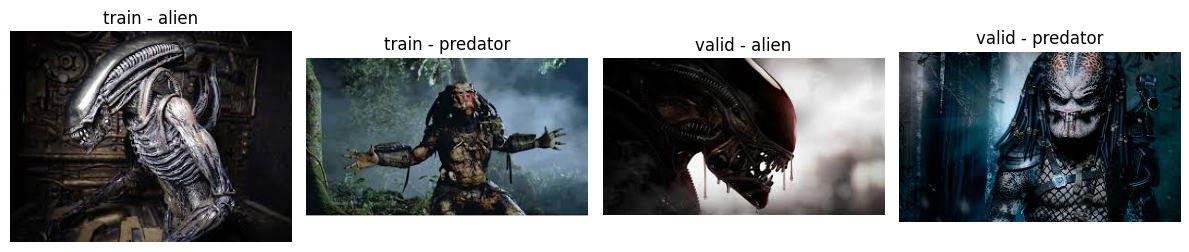

In [5]:
plot_images(img_list, ['train - alien','train - predator','valid - alien','valid - predator']  ) 

****
**Task 1.1:** Use the transformation defined above to convert the images into tensors and then  check some relevant features for the sample of images. Which shape do they have? What is the range of values? 
****


In [6]:
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
for image in img_list:

    torch_image = transform (image)
    
    print(f"Shape: {torch_image.shape}")
    print(f"Data type: {torch_image.dtype}")
    print(f"Min value: {torch_image.min()}")
    print(f"Max value: {torch_image.max()}")
    print(f"Median value: {torch_image.median()}\n")
    
#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################

Shape: torch.Size([3, 194, 259])
Data type: torch.float32
Min value: 0.0
Max value: 1.0
Median value: 0.08627451211214066

Shape: torch.Size([3, 168, 299])
Data type: torch.float32
Min value: 0.0
Max value: 1.0
Median value: 0.29411765933036804

Shape: torch.Size([3, 168, 300])
Data type: torch.float32
Min value: 0.0
Max value: 1.0
Median value: 0.11372549086809158

Shape: torch.Size([3, 175, 289])
Data type: torch.float32
Min value: 0.0
Max value: 1.0
Median value: 0.11372549086809158



# 2 Preprocessing

Now we know the dataset and we have defined the learning task: binary classification for images. As the dataset is quite small and the computation resources limited, in order to have a good classifier we will need to use transfer learning. We will use a pre-trained ResNet model over ImageNet.




****
**Question 2.1**
Preprocessing techniques should be consistent with the model choices. Do you think the current data format aligns with that of ImageNet? What additional preprocessing steps are necessary for preparing the images?


<font color="green">  
The shape of the images is (Channels, Height, Width), which corresponds to the ImageNet format. The images have varying heights and widths. The pixel values are scaled between 0 and 1. Therefore, we need to normalize the images according to ImageNet mean and standard deviation and resize them to 224x224.
</font>

****

The next step consists of defining the transformations for the preprocessing part. 

In [7]:
#Normalization
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

#Transformations
data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

In the transformation for the training set, you can see the additional transformations
```
transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
transforms.RandomHorizontalFlip(),
```
These transformations augment the training dataset by generating modified versions of the original training images by randomly applying affine transformations to the images as shearing, scaling, or flipping. 

We will cover data augmentation in Lecture 7. For now, it's important to note that these transformations are **only** applied to the training set. This is crucial to ensure a valid assessment of the model's performance; the validation and test sets must remain reliable representations of the model's performance on unseen, real-world data.


Now we create the dataset using DataLoader which efficiently load and batch data, enabling easy iteration over large datasets during training and evaluation.

In [8]:
#Set the seed
torch.manual_seed(42)

image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + 'validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)
}

# 3 Building and Training the Model
Now we first import the pre-treined ResNet model, we build our own model according to the problem we want to solve and then we train it. Let's start by checking that we are actually running the session on a GPU.

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


If the output you see "cpu", you must check that in Settings --> Accelerator you have chosen one of the GPU options. Otherwise, you will wait a little while training your model...

In [10]:
#Load the pretrained resnet model from torchvision models
model = models.resnet50(pretrained=True).to(device)

#Check the
print (summary(model ,(3,224,224)))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

****
**Question 3.1:** do you think there is anything we need to modify in the architecture of the network? Have a look at the last layer before answering.


In [11]:
#Check final layer 
print(model.fc)

Linear(in_features=2048, out_features=1000, bias=True)


<font color="green">  
The last fully connected layer has 1000 units, consistent with the object classification task for ImageNet. However, for this binary classification problem, we need a probability distribution over the two classes: aliens and predators
</font>

****

We now modify the network structure by replacing the last fully connected layer with two fully connected layers, whose parameters will learn the specific features of aliens and predators.

In [12]:
#Loop over all the parameters of the resnet model and...
for param in model.parameters():
    param.requires_grad = False

#Replace the resnet fully connected layer with two linear layers 
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

****
**Question 3.2:** What do you think `param.requires_grad = False` does? Which transfer learning techniques is being applied?


<font color="green">  
By setting `param.requires_grad = False` we prevent the gradients from being computed for these parameters. That means that the gradients will not be backpropagated through these layers. Then, we define new fully connected layers whose `param.requires_grad` is set to True by default. Therefore, we are freezing the parameters of the initial layers that are used as feature extractors, while allowing the new layers to learn task-specific features.
</font>

****

In [13]:
print(model.fc)

Sequential(
  (0): Linear(in_features=2048, out_features=128, bias=True)
  (1): ReLU(inplace=True)
  (2): Linear(in_features=128, out_features=2, bias=True)
)


Remember that the `CrossEntropyLoss` function takes *logits* as input, which are the raw, unscaled outputs of the model (without softmax applied), as it applies softmax internally.

In [14]:
#Define loss function
criterion = nn.CrossEntropyLoss()

#Define the optimizer
optimizer = optim.Adam(model.fc.parameters())

Note that we can specify that the Adam optimizer will only optimize the parameters of the last fully connected layers. 

Now we write the training function.

In [15]:
def train_model(model, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

Here we train the last layers with our training dataset.

In [16]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 0.6478, acc: 0.6297
validation loss: 0.4819, acc: 0.7550
Epoch 2/3
----------
train loss: 0.3950, acc: 0.8415
validation loss: 0.3011, acc: 0.9250
Epoch 3/3
----------
train loss: 0.2401, acc: 0.9164
validation loss: 0.2381, acc: 0.9300


Now, we save the model in the Kaggle environment. After running the following cell, you will find the model in the Output section on the left menu. Note that Kaggle does not retain the output between sessions, so if you wish to reuse the trained model, you will need to download it or store it elsewhere.

Specifically, we save the model weights and biases in a dictionary.

In [17]:
#Save the model
torch.save(model_trained.state_dict(), 'model_weights.h5')

To load a model with imported weights, we need to first define the model architecture, then we load the saved weights.

In [18]:
# Build the same architecture
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

#Load the dictionary of saved parameters
model.load_state_dict(torch.load('model_weights.h5'))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_23/420372891.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend

<All keys matched successfully>

# 4 Evaluation
Now, let's explore the model's results. We have already collected the training and validation loss and accuracy of the classifier. Since the class distribution is balanced, accuracy should serve as a reliable measure of the classifier's quality. To have a more concrete idea of our results, we will plot a few validation set images and check the model's predictions. This is always a good practice.

In [19]:
validation_img_paths = ['validation/alien/3.jpg',
                       'validation/alien/11.jpg',
                       'validation/alien/13.jpg',
                        'validation/alien/87.jpg',
                        'validation/predator/18.jpg',
                       'validation/predator/49.jpg',
                       'validation/predator/75.jpg',
                        'validation/predator/91.jpg']

validation_img_list = [Image.open(input_path + img_path) for img_path in validation_img_paths]

Here we build the input of the network. Remember that we need to apply the same transformation as before.

In [20]:
#Build the input for the network 
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in validation_img_list])

****
**Task 4.1:** Use the model to predict the probabilities assigned to all the images in the validation batch.
****

In [21]:
#############################################################################
#                           START OF YOUR CODE                              #
#############################################################################
pred_logits = model(validation_batch)
pred_probs = F.softmax(pred_logits, dim=1)
#############################################################################
#                            END OF YOUR CODE                               #
#############################################################################
print (pred_probs)

tensor([[0.6371, 0.3629],
        [0.8847, 0.1153],
        [0.7815, 0.2185],
        [0.8019, 0.1981],
        [0.4074, 0.5926],
        [0.1349, 0.8651],
        [0.0052, 0.9948],
        [0.0101, 0.9899]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


Now let's build the labels and plot the images with corresponding class and probability assigned by the model.

In [22]:
# Move the tensor datat to cpu 
pred_probs = pred_probs.cpu().data.numpy()

#Define the classes by the higher probability
classes = np.argmax(pred_probs,axis=1)

#Labels for the plot
labels = [] 

for i,label in enumerate(classes):
    if label == 0:
        labels.append('alien prob '+ str(pred_probs[i][0])) 
    else:
        labels.append('predator prob '+ str(pred_probs[i][1])) 

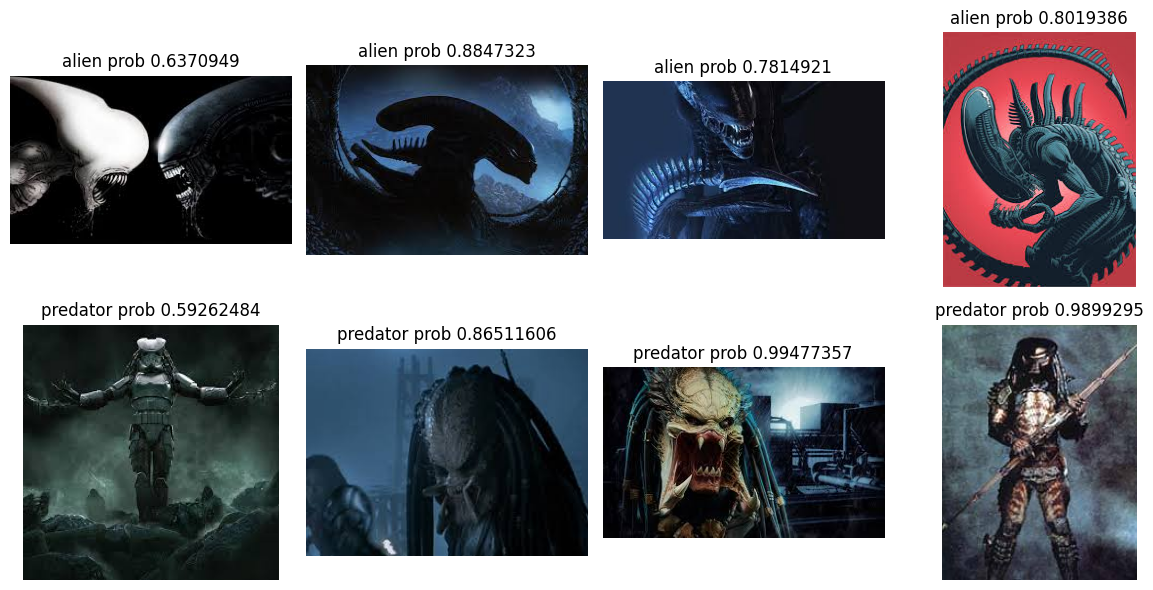

In [23]:
plot_images(validation_img_list,labels)

**That's all for now,see yo uat the next lab!**

**Feedback Form:** please fill in the following form to provide feedback https://forms.office.com/e/zV2zVMgFxR